# Computational Fact Checking Using Knowledge Graphs

**Necessary Import Statements**
Run this first.

In [2]:
%matplotlib inline

import sys
from enum import Enum
from collections import OrderedDict

import csv, math, string
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from scrapers import logger
from Truth import Page, get_truth_value, get_truth_value_old, get_utfidf, get_truth_matrices, get_mx


from sklearn.metrics import roc_curve, confusion_matrix, classification_report


from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

logger.ignorewarnings = True
color = plt.cm.Blues

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Leryc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\Users\Leryc\Envs\thesis\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Phase I: Classification Task (Calibration)

**Objective**

This phase is aimed to answer to objectives 1 & 3.
1. Compare the accuracy of using metric and ultra-metric closure for path evaluation.
2. Evaluate the accuracy of the path evaluation with cosine similarity and TF-IDF. 

**Method**

Statements in the form of "Politician $p_{i}$ endorses ideology $i_{j}$ are considered. A matrix of all possible combinations of subjects and objects were then obtained. Each path in the matrix was evaluated to obtain its truth value.

Truth matrices were obtained using these 3 algorithms:
1. Truth value matrix using metric closure, with TF-IDF and cosine similarity
2. Truth value matrix using ultrametric closure, with TF-IDF and cosine similarity
3. Truth value matrix using metric closure, using generality only (theoretical framework)

Using the truth values of the politicians mapped to the ideologies as features, the politicians will be classified into either republican (R) or democrat (D). The algorithm which results in the highest accuracy will be used for the succeeding phases of this study.

**Get truth matrices**

In [ ]:
# Uncomment this if making a truth matrix from scratch (takes a VERY long time)
# if truth matrices were already calculated, load from the CSV instead (bottom most part of this ntbk)

#df = pd.read_csv('data/out/i5/i5.csv', sep=';', index_col=0)
#mt, ut, mold = get_truth_matrices(df)
#i1_mt = mt

**Get target column**

In [5]:

# Democrat will be the positive class.
def isDemocrat(entity):
    return entity.endswith('(D)')
y = [isDemocrat(x) for x in i1_mt.index]

In [2]:
i1_mt[:5]

,Anarchism,Antisemitism,Capitalism,Christianity,Communism,Conservatism,Democracy,Fascism,Feminism,Islamophobia,Left-wing politics,Liberalism,Marxism,Nationalism,Neo-Nazism,Protestantism,Right-wing politics,Secularism,Socialism,White supremacy
x-entity,,,,,,,,,,,,,,,,,,,,
Jo Bonner (R),0.071048,0.067143,0.054021,0.053941,0.066685,0.072421,0.058368,0.065525,0.044251,0.069056,0.063660,0.053091,0.059485,0.065946,0.096082,0.054214,0.068126,0.050647,0.073818,0.063966
Martha Roby (R),0.067763,0.063282,0.064275,0.055059,0.067058,0.098936,0.083081,0.077397,0.062446,0.057294,0.074704,0.075141,0.054051,0.060333,0.089473,0.058659,0.089053,0.064666,0.087194,0.065397
Mike Rogers (R),0.069972,0.066444,0.064401,0.050256,0.058977,0.055445,0.054687,0.070131,0.044306,0.056108,0.069981,0.060342,0.046575,0.076550,0.089277,0.061955,0.056137,0.051539,0.070631,0.057534
Robert Aderholt (R),0.099980,0.078978,0.073372,0.070627,0.093934,0.122361,0.084522,0.092721,0.059072,0.064086,0.092826,0.090079,0.060709,0.079224,0.133379,0.076984,0.105611,0.072566,0.100810,0.083287
Mo Brooks (R),0.086297,0.081946,0.081745,0.072008,0.090412,0.113233,0.091384,0.096122,0.056169,0.061632,0.089806,0.085677,0.059916,0.089592,0.118347,0.073699,0.095786,0.063528,0.104593,0.094316


### Classification using Metric Closure WITH TF-IDF/COSINE SIMILARITY MATRIX

**Classify the truth values into R or D using SVM with linear kernel, and assess accuracy using 10-fold cross validation**

Mean cross-validation accuracy: 0.66
             precision    recall  f1-score   support

      False       0.66      0.67      0.67       137
       True       0.67      0.66      0.66       138

avg / total       0.67      0.67      0.67       275



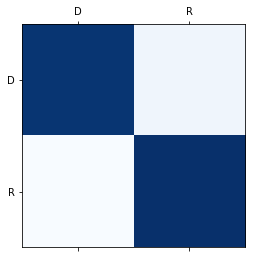

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as ps
from sklearn.model_selection import cross_val_score 

#from sklearn.neighbors import KNeighborsClassifier
kf = KFold(n_splits=10)
#knn = KNeighborsClassifier(n_neighbors=3)
svm_clf = SVC(C=2**15, kernel='linear')


scoresw = cross_val_score(svm_clf,i1_mt,y,cv=kf)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scoresw)))

ypred = cross_val_predict(svm_clf, i1_mt, y, cv=kf)
print(classification_report(y, ypred, digits=2))
conf_mx = confusion_matrix(y, ypred, labels=[True, False])
plt.matshow(conf_mx,cmap=plt.cm.Blues)

plt.xticks(np.arange(2), ['D', 'R'])
plt.yticks(np.arange(2), ['D', 'R'])
plt.savefig('figures/classification/metric_tfidf_confmx.pdf')
plt.show()


**Display ROC Curve**

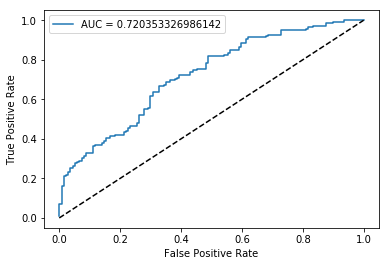

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_scores = cross_val_predict(svm_clf, i1_mt, y, cv=kf, method="decision_function")
fpr, tpr, thresholds = roc_curve(y, y_scores)

fpr, tpr, thresh = roc_curve(y, y_scores)
auc = roc_auc_score(y, y_scores)
plt.plot(fpr,tpr,label="AUC = "+repr(auc))

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=0)

plt.savefig('figures/classification/metric_tfidf_roc.pdf', format='pdf')

**F1 SCORE**

In [10]:
from sklearn.metrics import f1_score
m_f1 = f1_score(y, ypred, average='macro')  
print(f"F1 Score: {m_f1}")

F1 Score: 0.6654501216545012


In [11]:
len(i1_ut)

275

## Classification Using Ultrametric Closure with TF-IDF/Cosine Similarity

Mean cross-validation accuracy: 0.57
             precision    recall  f1-score   support

      False  0.5714285714 0.5547445255 0.5629629630       137
       True  0.5704225352 0.5869565217 0.5785714286       138

avg / total  0.5709237242 0.5709090909 0.5707955748       275



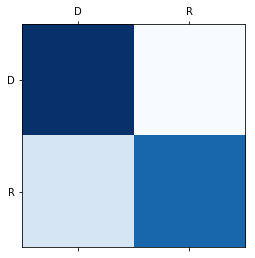

F1 Score: 0.5707671957671958


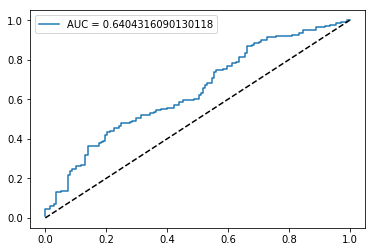

In [11]:
def isDemocrat(entity):
    return entity.endswith('(R)')

from sklearn.svm import SVC
svm_clf = SVC(C=2**14, kernel='linear')

from sklearn.model_selection import cross_val_score 
scoresw = cross_val_score(svm_clf,i1_ut,y,cv=kf)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scoresw)))

ypred = cross_val_predict(svm_clf, i1_ut, y, cv=kf)
print(classification_report(y, ypred, digits=10))
conf_mx = confusion_matrix(y, ypred, labels=[True, False])
plt.matshow(conf_mx,cmap=plt.cm.Blues)
plt.xticks(np.arange(2), ['D', 'R'])
plt.yticks(np.arange(2), ['D', 'R'])
plt.savefig('figures/classification/ultrametric_tfidf_confmx.pdf')
plt.show()

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

yw_scores = cross_val_predict(svm_clf, i1_ut, y, cv=kf, method="decision_function")
fpr, tpr, thresholds = roc_curve(y, yw_scores)

fpr, tpr, thresh = roc_curve(y, yw_scores)
auc = roc_auc_score(y, yw_scores)
plt.plot(fpr,tpr,label="AUC = "+repr(auc))

plt.plot([0,1],[0,1],'k--')

plt.legend(loc=0)
plt.savefig('figures/classification/ultrametric_tfidf_roc.pdf')
from sklearn.metrics import f1_score
u_f1 = f1_score(y, ypred, average='macro')  
print(f"F1 Score: {u_f1}")

## Classification Task using METRIC Closure as generality (theoretical framework)


Mean cross-validation accuracy: 0.61
             precision    recall  f1-score   support

      False  0.5892857143 0.7226277372 0.6491803279       137
       True  0.6448598131 0.5000000000 0.5632653061       138

avg / total  0.6171738075 0.6109090909 0.6060666079       275



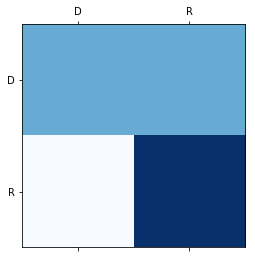

F1 Score: 0.6062228169956507


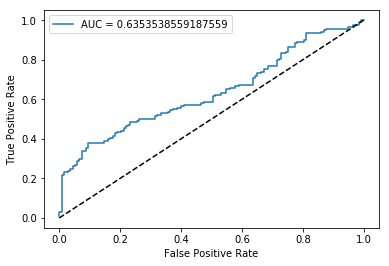

In [12]:

def isDemocrat(entity):
    return entity.endswith('(R)')

from sklearn.svm import SVC
svm_clf = SVC(C=2**15, kernel='linear')

from sklearn.model_selection import cross_val_score 
scoresw = cross_val_score(svm_clf,i1_mold,y,cv=kf)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scoresw)))

ypred = cross_val_predict(svm_clf, i1_mold, y, cv=kf)

print(classification_report(y, ypred, digits=10))
conf_mx = confusion_matrix(y, ypred, labels=[True,False])
plt.matshow(conf_mx,cmap=plt.cm.Blues)
plt.xticks(np.arange(2), ['D', 'R'])
plt.yticks(np.arange(2), ['D', 'R'])
plt.savefig('figures/classification/mold_confmx.pdf')
plt.show()

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_scores = cross_val_predict(svm_clf, i1_mold, y, cv=kf, method="decision_function")

fpr, tpr, thresholds = roc_curve(y, y_scores)

fpr, tpr, thresh = roc_curve(y, y_scores)
auc = roc_auc_score(y, y_scores)
plt.plot(fpr,tpr,label="AUC = "+repr(auc))

plt.plot([0,1],[0,1],'k--')

plt.legend(loc=0)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('figures/classification/mold_roc.pdf')

# F1 Score
from sklearn.metrics import f1_score

mold_f1 = f1_score(y, ypred, average='macro')  
print(f"F1 Score: {mold_f1}")


## Results
The first algorithm, Metric Closure with TF-IDF+Cosine Similarity was more accurate in classifying the politicians, hence, Metric Closure with TF-IDF+Cosine Similarity is better at calculating the semantic proximity and truth values of the politicans to the ideologies, and will be used in the succeeding parts of this paper.

# Validation on Factual Statements

Simple statements various subject areas were tested. Statements in the form of "$p_{i}$ was married to $s_{j}$" were considered, where $p_{i}$ is a US president, and $s_{j}$ is a spouse of a US president. A matrix of statements was then obtained by getting all the combinations of subjects and objects.

**Get the paths taken by the statements in the knowledge graph.**

In [ ]:
# Uncomment these line(s) below if making a truth matrix from scratch (takes a VERY long time)
# if truth matrices were already calculated, load from the CSV instead (bottom most part of this ntbk)
#df = pd.read_csv('data/out/t2_output.csv', sep=';', index_col=0)
#print(df.shape)

**Map the truth value function to the Path matrix.**

In [ ]:
# Uncomment these line(s) below if making a truth matrix from scratch (takes a VERY long time)
# if truth matrices were already calculated, load from the CSV instead (bottom most part of this ntbk)
#w_new, w_u_new, w_mold = get_truth_matrices(df)

**Get the confusion matrix of the truth values**

Confusion Matrix


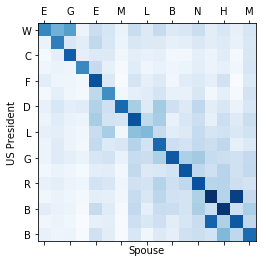

In [15]:
fig, ax = plt.subplots(1,1)
plt.xlabel('Spouse')
plt.ylabel('US President')

ax.matshow(w_new, cmap=color)
ax.set_xticklabels([' ']+[x[0] for x in w_new.keys()][::2])
ax.set_yticklabels([' ']+[x[0] for x in w_new.index][::2])
print("Confusion Matrix")

fig.savefig('figures/phase2/president_spouse.pdf')

**Get F1 Score**

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

vfs_w_y, vfs_w_y_score = get_mx(w_new)
ypred = cross_val_predict(svm_clf, vfs_w_y_score.reshape(-1,1), vfs_w_y, cv=kf)

from sklearn.metrics import f1_score
m_f1 = f1_score(vfs_w_y, ypred)  
print(f"F1 Score: {m_f1}")


F1 Score: 0.9142857142857143


### Validation of World Capitals

In [ ]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
#df_capitals = pd.read_csv('data/out/t3_countries.csv', sep=';', index_col=0)
#df_capitals.shape

**Map the truth value function to the matrix**

In [ ]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
#c_new, c_u_new, c_u_mold = get_truth_matrices(df_capitals)

**Show confusion matrix**

Confusion Matrix


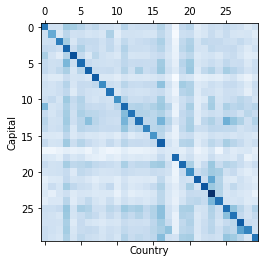

In [16]:
fig, ax = plt.subplots(1,1)
plt.xlabel('Country')
plt.ylabel('Capital')
ax.matshow(c_new, cmap=color)
print("Confusion Matrix")
fig.savefig('figures/phase2/capital_country.pdf')

**Calculate F1 Score**

In [18]:
vfs2_y, vfs2_y_score = get_mx(c_new)
ypred = cross_val_predict(svm_clf, vfs2_y_score.reshape(-1,1), vfs2_y, cv=kf)
from sklearn.metrics import f1_score
t2_f1 = f1_score(vfs2_y, ypred)  
print(f"F1 Score: {t2_f1}")

F1 Score: 0.9655172413793104


### Validation of Directors / Movies

In [216]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.df_movies = pd.read_csv('data/out/t4_movies.csv', sep=';', index_col=0, encoding='utf-8')
#df_movies.shape

**Map the truth value function to the matrix**

In [217]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
#d_new, d_u_new, d_mold = get_truth_matrices(df_movies)

Confusion matrix


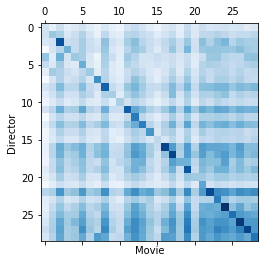

In [17]:
fig, ax = plt.subplots(1,1)
plt.xlabel('Movie')
plt.ylabel('Director')
ax.matshow(d_new, cmap=color)
print("Confusion matrix")
fig.savefig('figures/phase2/2_confmx_movies.pdf')

**Calculate F1 Score**

F1 Score was not so high, since the results for this task has a high false positive rate (see results and discussions).

In [24]:
vfs2_y, vfs2_y_score = get_mx(d_new)
ypred = cross_val_predict(svm_clf, vfs2_y_score.reshape(-1,1), vfs2_y, cv=kf)
from sklearn.metrics import f1_score
t2_f1 = f1_score(vfs2_y, ypred)  
print(f"F1 Score: {t2_f1}")

F1 Score: 0.3888888888888889


### Validation of US State Capitals

In [ ]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
#df_states = pd.read_csv('data/out/t5_states.csv', sep=';', index_col=0, encoding='utf-8')
#df_states.shape

In [ ]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
#s_new, s_u_new, s_mold = get_truth_matrices(df_states)

Confusion matrix


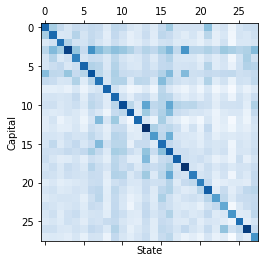

In [20]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
plt.xlabel('State')
plt.ylabel('Capital')
ax.matshow(s_new, cmap=color)
print("Confusion matrix")
fig.savefig('figures/phase2/2_confmx_states.exe', format='pdf')

**Get F1 Score**

In [26]:
vfs2_y, vfs2_y_score = get_mx(s_new)
ypred = cross_val_predict(svm_clf, vfs2_y_score.reshape(-1,1), vfs2_y, cv=kf)
from sklearn.metrics import f1_score
t2_f1 = f1_score(vfs2_y, ypred)  
print(f"F1 Score: {t2_f1}")

F1 Score: 0.9090909090909091


### Aggregation

[0.34989304 0.26557676 0.25118927 0.24763552 0.24631537 0.23613277
 0.22471282 0.22328377 0.08567668]


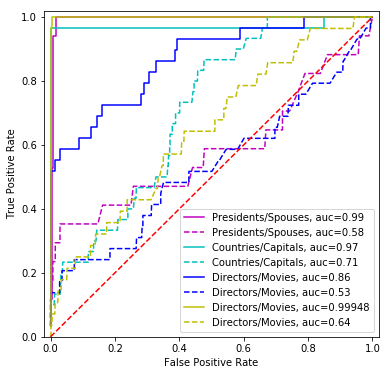

In [13]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

#======SPOUSES===================================================================
#plt.figure().clf()
#ax.figure()
y, y_score = get_mx(w_new)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'m-',label="Presidents/Spouses, auc={:.2f}".format(auc))
#------------------------------------------------------------------
y, y_score = get_mx(w_mold)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'m--',label="Presidents/Spouses, auc={:.2f}".format(auc))
#======COUNTRIES===================================================================
y, y_score = get_mx(c_new)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'c-',label="Countries/Capitals, auc={:.2f}".format(auc))

#------------------------------------------------------------------
y, y_score = get_mx(c_u_mold)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'c--',label="Countries/Capitals, auc={:.2f}".format(auc))
#======DIRECTORS===================================================================
y, y_score = get_mx(d_new)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'b-',label="Directors/Movies, auc={:.2f}".format(auc))

#------------------------------------------------------------------
y, y_score = get_mx(d_mold)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'b--',label="Directors/Movies, auc={:.2f}".format(auc))
#======STATES===================================================================
y, y_score = get_mx(s_new)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'y-',label="Directors/Movies, auc={:.5f}".format(auc))

print(thresh)

#------------------------------------------------------------------
y, y_score = get_mx(s_mold)
fpr, tpr, thresh = metrics.roc_curve(y, y_score)
auc = metrics.roc_auc_score(y, y_score)
ax.plot(fpr,tpr,'y--',label="Directors/Movies, auc={:.2f}".format(auc))


ax.plot([0,1],[0,1],'r--')



ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
#ax.tight_layout()

# remove this code to remove the border
ax.set_ylim(0, 1.02)
ax.set_xlim(-0.02, 1.02)

ax.legend(loc=0)

## Validation on annotated corpus

**Read the list of GREC statements and their corresponding paths**

In [33]:
import pandas as pd
import numpy as np
grec_paths = pd.read_csv("data/GREC/grec_final/gt_with_paths.csv",  encoding='utf-8', sep=';', index_col=0)
grec_paths[:5]

,predicate,object,score,path
subject,,,,
Morris S. Miller,/people/person/place_of_birth,New York City,5,"Morris S. Miller>Buffalo, New York>New York City"
Max Ferguson (painter),/people/person/place_of_birth,New York City,5,Max Ferguson (painter)>New York University>Ber...
John J. Dunnigan,/people/person/place_of_birth,New York City,5,John J. Dunnigan>New York (state)>Arabic>New Y...
Frederick Juengling,/people/person/place_of_birth,New York City,5,Frederick Juengling>Berlin>New York City
Reuel Denney,/people/person/place_of_birth,New York City,5,"Reuel Denney>Buffalo, New York>New York City"


**Get truth series**

In [ ]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
#grec_m, grec_u, grec_u2 = get_grec_truth_series(grec_paths)

In [ ]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
#WRITE 
#grec.to_csv('data/GREC/pob1k/gt_with_truthvals.csv', encoding='utf-8', sep=';')
#READ
#grec_m = pd.read_csv('data/GREC/pob1k/gt_with_truthvals.csv', encoding='utf-8', sep=';', index_col=0)

In [ ]:
# Uncomment these line(s) below if calculating truth values from scratch.
# Otherwise, load the CSVs at the bottom of this ntbk.
# Run only if truth_series was not yet calculated. Otherwise skip to 3rd cell.
#grec_m, grec_u, grec_mold = get_grec_truth_series(grec)

**See the truth scores**

Column "path" is the predicted score given by the algorithm, and Column "score" is the aggregated score of human fact checkers, and can range from -5 to +5 (-5 with all raters having rated the statement 'false', and +5 with all raters having rated the statement 'true')

In [228]:
grec_m["path"] = grec_m["path"].astype('float64')
grec_m[:3]

,subject,predicate,object,score,path
0,Morris S. Miller,/people/person/place_of_birth,New York City,5.0,0.193146
1,Max Ferguson (painter),/people/person/place_of_birth,New York City,5.0,0.295168
2,John J. Dunnigan,/people/person/place_of_birth,New York City,5.0,0.184989


**Drop all nan values**

These nan values were unretrievable paths (due to Wikidata entity no longer existing)

In [229]:
grec_m = grec_m.dropna()

**See correlation Graph**

The correlation of human fact checker scores vs. the computational fact checking algorithm.

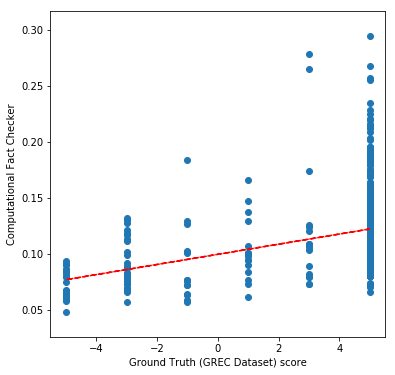

In [7]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
x = grec_m['score']
y = grec_m['path']

fig, ax = plt.subplots(1,1,figsize=(6,6))
bb, m = polyfit(x, y, 1)

ax.scatter(x,y)
ax.plot(x, bb + m * x, 'r--')
ax.set_ylabel("Computational Fact Checker")
ax.set_xlabel("Ground Truth (GREC Dataset) score")
fig.savefig('figures/grec/pob_correlation.pdf', format='pdf')

**Calculate Spearman and Kendall's $\tau$ Correlation value between**

In [231]:
from scipy.stats import pearsonr, spearmanr, kendalltau
r, pval = spearmanr(grec_m["score"], grec_m["path"])
r_tau, pval_tau = kendalltau(grec_m["score"], grec_m["path"])

print("Spearman Correlation")
print (r)
print (pval)
print("Tau Correlation")
print (r_tau)
print (pval_tau)

Spearman Correlation
0.40276840498587074
6.349433264873441e-21
Tau Correlation
0.3171971308063854
2.0270123085891602e-19


There is a correlation between the human fact checkers and the computational fact checking method, thus satisfying objective #3. For reference, here is the ROC curve, using the GREC dataset as ground truth.

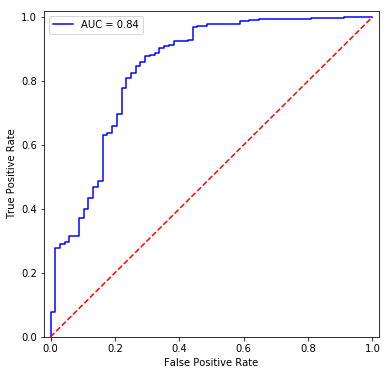

In [242]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

z = lambda x: x>0
fig, ax = plt.subplots(figsize=(6,6))
y = [z(x) for x in grec_m['score']]
fpr, tpr, thresh = roc_curve(y, grec_m['path'])
auc = roc_auc_score(y, grec_m['path'])
ax.plot(fpr,tpr,'b-',label="AUC = {:.2f}".format(auc))
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
#ax.tight_layout()
# remove this code to remove the border
ax.set_ylim(0, 1.02)
ax.set_xlim(-0.02, 1.02)

ax.legend(loc=0)
fig.savefig("figures/Validation on Annotated Corpus/ROC_Validation_on_Annotated_Corpus.pdf", bbox_inches='tight')
fig.savefig("figures/Validation on Annotated Corpus/ROC_Validation_on_Annotated_Corpus.png", bbox_inches='tight', format='png')

### Validation on Degrees

In [ ]:
import pandas as pd
import numpy as np
grec_paths = pd.read_csv("data/GREC/GREC_degree/gt_with_paths.csv",  encoding='utf-8', sep=';', index_col=0)
grec_paths[:5]

In [ ]:
grec_m2, grec_u2, grec_mold2 = get_grec_truth_series(grec_paths)

In [124]:
grec_m2 = grec_m2.dropna()

In [43]:
from scipy.stats import pearsonr, spearmanr, kendalltau
r, pval = spearmanr(grec_m2["score"], grec_m2["path"])
r_tau, pval_tau = kendalltau(grec_m2["score"], grec_m2["path"])

print("Spearman Correlation")
print (r)
print (pval)
print("Tau Correlation")
print (r_tau)
print (pval_tau)

Spearman Correlation
0.24988641492145977
1.4810703681758453e-08
Tau Correlation
0.19662283194111033
2.6569565626479824e-08


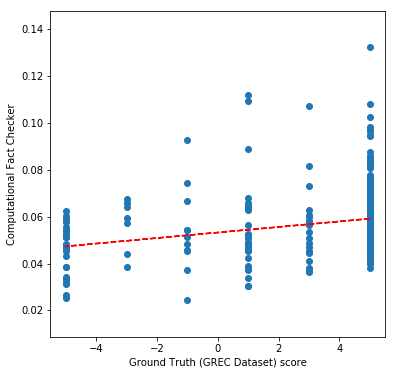

In [42]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
x = grec_m2['score'].astype('float64')
y = grec_m2['path'].astype('float64')

fig, ax = plt.subplots(1,1,figsize=(6,6))
bb, m = polyfit(x, y, 1)

ax.scatter(x,y)
ax.plot(x, bb + m * x, 'r--')
ax.set_ylabel("Computational Fact Checker")
ax.set_xlabel("Ground Truth (GREC Dataset) score")
fig.savefig('figures/pob_correlation2.pdf', format='pdf')

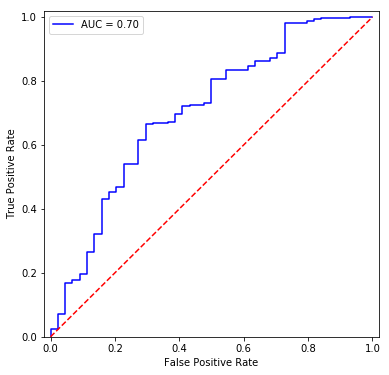

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

z = lambda x: x>0
fig, ax = plt.subplots(figsize=(6,6))
y = [z(x) for x in grec_m2['score']]
fpr, tpr, thresh = roc_curve(y, grec_m2['path'])
auc = roc_auc_score(y, grec_m2['path'])
ax.plot(fpr,tpr,'b-',label="AUC = {:.2f}".format(auc))
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
#ax.tight_layout()
# remove this code to remove the border
ax.set_ylim(0, 1.02)
ax.set_xlim(-0.02, 1.02)

ax.legend(loc=0)
fig.savefig("figures/grec_roc2.pdf", bbox_inches='tight')
#fig.savefig("figures/Validation on Annotated Corpus/ROC_Validation_on_Annotated_Corpus.png2", bbox_inches='tight', format='png')

## Other Utilities

In [4]:
import time
from Truth import get_truth_value, get_utfidf, get_truth_value_old
def get_grec_truth_series(df):
    """
    Returns 3 pandas dataframes:
        - metric_tfidf
        - umetric_tfidf
        - metric_old
    """
    metric_tfidf = df.copy()
    umetric_tfidf = df.copy()
    metric_old = df.copy()
    metric_tfidf.is_copy=False
    umetric_tfidf.is_copy=False
    metric_old.is_copy=False
    for idx, rowidx in enumerate(df.index):
        print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>'+str(rowidx))
        start = time.time()
        print(f"[{idx+1}/{len(df.index)}] {df.loc[rowidx, 'path']}")
        try:
            metric_tfidf.loc[rowidx,"path"] = get_truth_value(metric_tfidf.loc[rowidx,"path"], display=False)
            umetric_tfidf.loc[rowidx,"path"] = get_utfidf(umetric_tfidf.loc[rowidx,"path"],display=False)
            metric_old.loc[rowidx, "path"] = get_truth_value_old(metric_old.loc[rowidx,"path"],display=False)
        except:
            print(f"Value error occured @ {metric_tfidf.loc[rowidx,'path']}.")
            print(f"Putting nan as value")
            metric_tfidf.loc[rowidx,"path"] = np.nan
            umetric_tfidf.loc[rowidx,"path"] = np.nan
            metric_old.loc[rowidx, "path"] = np.nan
            
        print(f"Done {time.time()-start} seconds. m:{metric_tfidf.loc[rowidx]['path']}; u:{umetric_tfidf.loc[rowidx]['path']}; mo:{metric_old.loc[rowidx]['path']}")
    metric_tfidf.loc['path']= metric_tfidf['path'].astype('float64')
    umetric_tfidf.loc['path']=umetric_tfidf['path'].astype('float64')
    metric_old.loc['path']=metric_old['path'].astype('float64')
    return (metric_tfidf.drop("path", axis=0), umetric_tfidf.drop("path", axis=0), metric_old.drop("path", axis=0))

## Other Utilities

Save the loaded CSVs for future use. Only uncomment the variables needed.

In [24]:
# Uncomment the variables you're gonna be saving.
# CAUTION: This will override existing CSV.

#=========================================
# Phase I: Classification Task
#=========================================
#mold.to_csv('data/out/degmatrices/i2_mold.csv', sep=';')
#mt.to_csv('data/out/degmatrices/i2_mt.csv', sep=';')
#ut.to_csv('data/out/degmatrices/i2_ut.csv', sep=';')

#=========================================
# Phase II: Validation on Factual Data
#=========================================
# Countries/Capitals
#c_new.to_csv('data/out/degmatrices/t3_countries/c_new.csv', sep=';')
#c_u_new.to_csv('data/out/degmatrices/t3_countries/c_u_new.csv', sep=';')
#c_u_mold.to_csv('data/out/degmatrices/t3_countries/c_u_mold.csv', sep=';')
#-----------------------------------------
# Presidents/Spouses
#w_new.to_csv('data/out/degmatrices/t2_presidents/w_new.csv', sep=';')
#w_u_new.to_csv('data/out/degmatrices/t2_presidents/w_u_new.csv', sep=';')
#w_mold.to_csv('data/out/degmatrices/t2_presidents/w_mold.csv', sep=';')
#-----------------------------------------
# Director/Movie
#d_new.to_csv('data/out/degmatrices/t4_movies/d_new.csv', sep=';')
#d_u_new.to_csv('data/out/degmatrices/t4_movies/d_u_new.csv', sep=';')
#d_mold.to_csv('data/out/degmatrices/t4_movies/d_mold.csv', sep=';')
#-----------------------------------------
# US State Capitals
#s_new.to_csv('data/out/degmatrices/t5_states/s_new.csv', sep=';')
#s_u_new.to_csv('data/out/degmatrices/t5_states/s_u_new.csv', sep=';')
#s_mold.to_csv('data/out/degmatrices/t5_states/s_mold.csv', sep=';')

#=========================================
# Phase II: Validation on Annotated Data
#=========================================
#grec_m.to_csv('data/GREC/grec_final/gt_with_truthvals.csv', sep=';')
#grec_m2.to_csv('data/GREC/GREC_degree/gt_with_truthvals.csv', sep=';')

Load the , and concat

In [41]:
# Uncomment the variables that will be used.
import pandas as pd
#=========================================
# Phase I: Classification Task
#=========================================
i1_mt =  pd.read_csv('data/out/degmatrices/i1_mt.csv', sep=';', index_col=0)
i2_mt =  pd.read_csv('data/out/degmatrices/i2_mt.csv', sep=';', index_col=0)
i1_mt = pd.concat([i1_mt,i2_mt])
i1_ut =  pd.read_csv('data/out/degmatrices/i1_ut.csv', sep=';', index_col=0)
i2_ut =  pd.read_csv('data/out/degmatrices/i2_ut.csv', sep=';', index_col=0)
i1_ut = pd.concat([i1_ut,i2_ut])
i1_mold =  pd.read_csv('data/out/degmatrices/i1_mold.csv', sep=';', index_col=0)
i2_mold =  pd.read_csv('data/out/degmatrices/i2_mold.csv', sep=';', index_col=0)
i1_mold = pd.concat([i1_mold,i2_mold])
i1_mold.to_csv('data/out/degmatrices/ide_mold.csv', sep=';')
#i1_mt = pd.read_csv('data/out/degmatrices/ide.csv', sep=';', index_col=0)

#=========================================
# Phase II: Validation on Factual Data
#=========================================
# Presidents/Spouses
w_new = pd.read_csv('data/out/degmatrices/t2_presidents/w_new.csv', sep=';', index_col=0)
w_u_new = pd.read_csv('data/out/degmatrices/t2_presidents/w_u_new.csv', sep=';', index_col=0)
w_mold = pd.read_csv('data/out/degmatrices/t2_presidents/w_mold.csv', sep=';', index_col=0)
#-----------------------------------------
# Countries/Capitals
c_new =  pd.read_csv('data/out/degmatrices/t3_countries/c_new.csv', sep=',', index_col=0)
c_u_new =  pd.read_csv('data/out/degmatrices/t3_countries/c_u_new.csv', sep=',', index_col=0)
c_u_mold =  pd.read_csv('data/out/degmatrices/t3_countries/c_u_mold.csv', sep=',', index_col=0)
#-----------------------------------------
# Director/Movie
d_new = pd.read_csv('data/out/degmatrices/t4_movies/d_new.csv', sep=';', index_col=0)
d_u_new = pd.read_csv('data/out/degmatrices/t4_movies/d_u_new.csv', sep=';', index_col=0)
d_mold = pd.read_csv('data/out/degmatrices/t4_movies/d_mold.csv', sep=';', index_col=0)
#-----------------------------------------
# US State Capitals
s_new = pd.read_csv('data/out/degmatrices/t5_states/s_new.csv', sep=';', index_col=0)
s_u_new = pd.read_csv('data/out/degmatrices/t5_states/s_u_new.csv', sep=';', index_col=0)
s_mold = pd.read_csv('data/out/degmatrices/t5_states/s_mold.csv', sep=';', index_col=0)

#=========================================
# Phase II: Validation on Annotated Data
#=========================================
grec_m = pd.read_csv('data/GREC/grec_final/gt_with_truthvals.csv', sep=';', index_col = 0)
grec_m2 = pd.read_csv('data/GREC/GREC_degree/gt_with_truthvals.csv', sep=';', index_col = 0)

In [14]:
mold.to_csv('data/classification/new_mold.csv', sep=';', encoding='utf-8')
ut.to_csv('data/classification/new_ut.csv', sep=';', encoding='utf-8')
mt.to_csv('data/classification/new_mt.csv', sep=';', encoding='utf-8')

In [4]:
mt.to_csv('data/out/degmatrices/i5_m.csv', sep=';', encoding='utf-8')
ut.to_csv('data/out/degmatrices/i5_u.csv', sep=';', encoding='utf-8')
mold.to_csv('data/out/degmatrices/i5_mold.csv', sep=';', encoding='utf-8')